In [53]:
from keys import client_id, client_secret, user_name
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2
import random
from functools import reduce

In [54]:
scope = 'user-library-read playlist-modify-public playlist-read-private user-read-recently-played app-remote-control user-top-read'

redirect_uri = 'https://developer.spotify.com/dashboard/applications/0743a195f7654b5ab95560a95e89316a'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

token = util.prompt_for_user_token(user_name, scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("NO TOKEN FOUND")


In [55]:
user_top_tracks = sp.current_user_top_tracks(limit=50, offset=0, time_range='long_term')
song_data = user_top_tracks["items"]

song_ids = []
song_names = []

for i in range(0, len(song_data)):
    if song_data[i]['id'] != None:
        song_ids.append(song_data[i]['id'])
        song_names.append(song_data[i]['name'])

song_features = []
for i in range(0, len(song_ids)):
    features = sp.audio_features(song_ids[i])
    for song in features:
        song_features.append(song)

top_tracks_df = pd.DataFrame(song_features, index=song_names)
top_tracks_df = top_tracks_df[["id", "acousticness", "danceability", "duration_ms", 
                         "energy", "instrumentalness",  "key", "liveness",
                         "loudness", "mode", "speechiness", "tempo", "valence"]]
top_tracks_df.head()

,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
HOLIDAY,6zFMeegAMYQo0mt8rXtrli,0.12000,0.810,154998,0.511,0.000000,5,0.0832,-6.924,0,0.1640,151.947,0.837
Death of a Bachelor,1BECwm5qkaBwlbfo4kpYx8,0.01370,0.462,203507,0.538,0.000000,0,0.4290,-5.527,1,0.0590,139.256,0.405
Daylight,6Ed1q0X8oSKSm4IIhiQbYg,0.00488,0.528,163906,0.749,0.000096,7,0.0949,-7.571,1,0.0479,163.944,0.729
Knock Knock,3uYm4MtU6jUQft2DtGqEoZ,0.03530,0.667,202807,0.922,0.000000,4,0.3640,-4.857,0,0.1280,108.952,0.509
Don't Matter,7I6DceMT3utDOHjcYCbrr4,0.24400,0.798,293053,0.443,0.000000,2,0.3260,-6.062,1,0.0403,125.232,0.354


In [56]:
top_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, HOLIDAY to Team
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                50 non-null     object 
 1   acousticness      50 non-null     float64
 2   danceability      50 non-null     float64
 3   duration_ms       50 non-null     int64  
 4   energy            50 non-null     float64
 5   instrumentalness  50 non-null     float64
 6   key               50 non-null     int64  
 7   liveness          50 non-null     float64
 8   loudness          50 non-null     float64
 9   mode              50 non-null     int64  
 10  speechiness       50 non-null     float64
 11  tempo             50 non-null     float64
 12  valence           50 non-null     float64
dtypes: float64(9), int64(3), object(1)
memory usage: 5.5+ KB


/Users/MatthewAlbert/.local/share/virtualenvs/DJ_NumPy-RDDxY7Pi/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


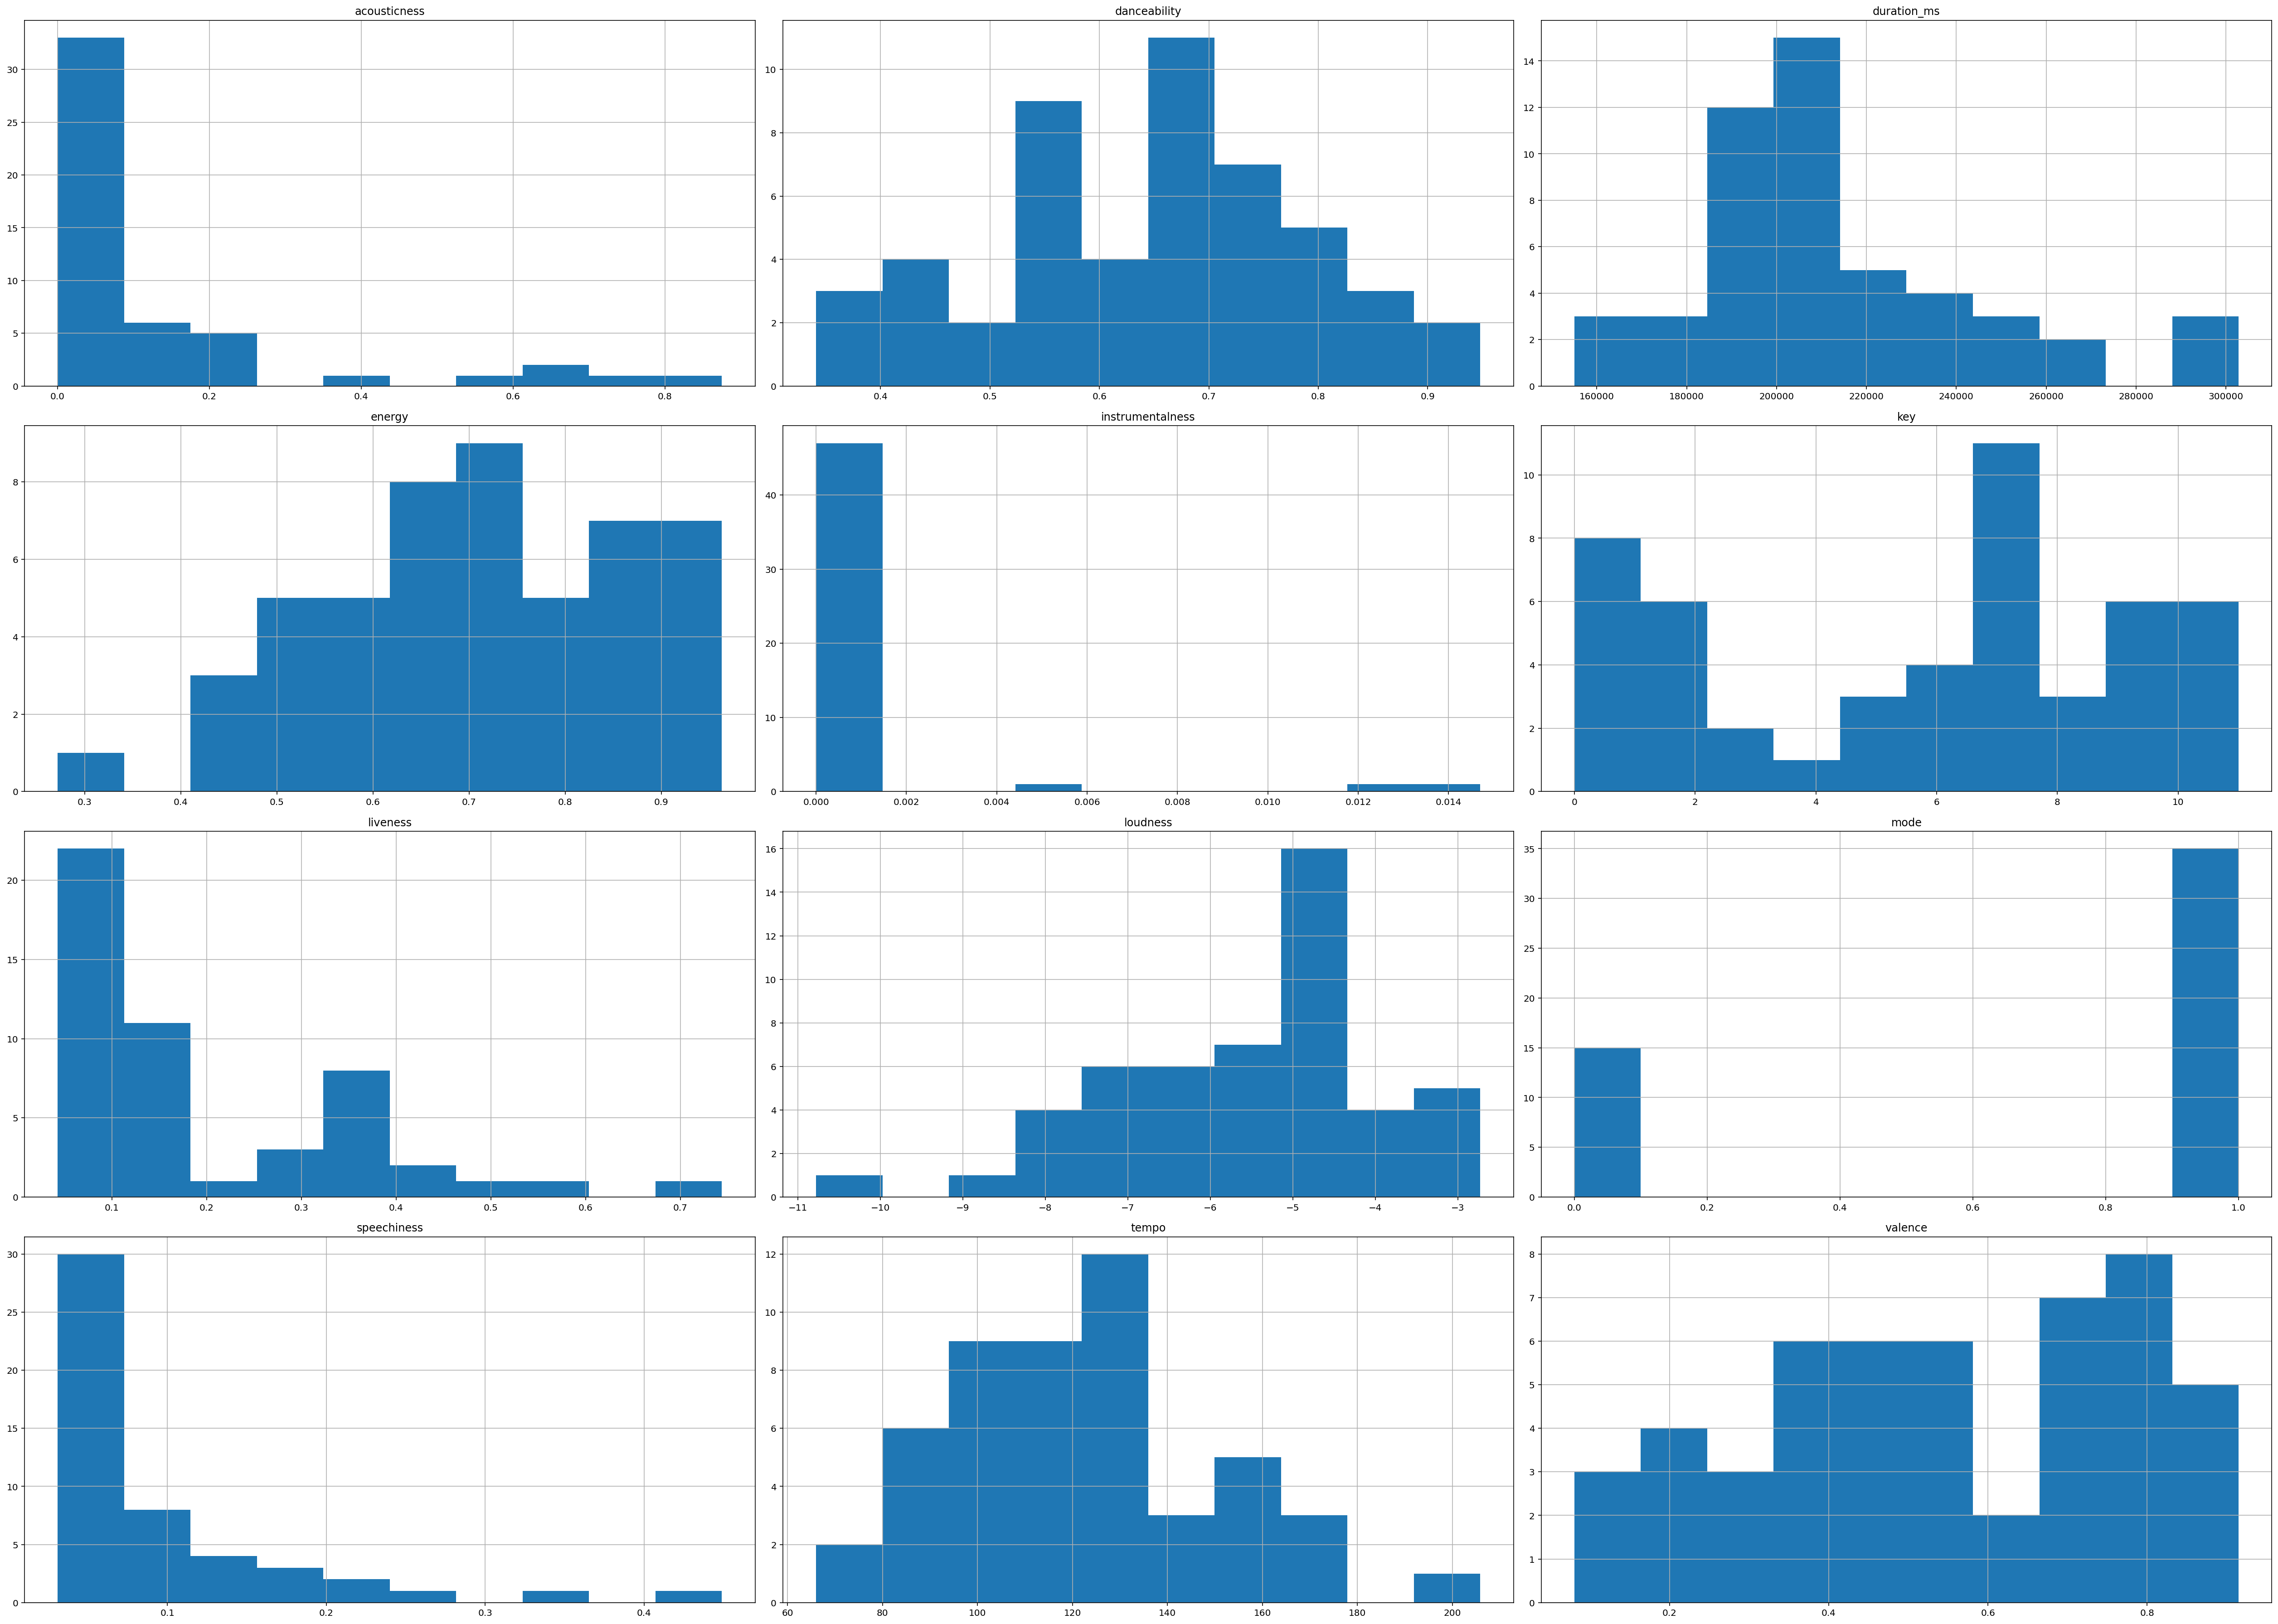

In [57]:
top_tracks_df.hist(figsize=(35,25)) 
plt.tight_layout()
plt.show()

In [58]:
featured_playlists = sp.featured_playlists(limit=50)
# Creating data frame for playlists
id = []
name = []
num_tracks = []
items = featured_playlists['playlists']['items']
for item in items:
    id.append(item["id"])
    name.append(item["name"])
    num_tracks.append(item["tracks"]["total"])

df_pl_data = pd.DataFrame({"id":id, "name": name, "num_tracks": num_tracks})

In [59]:
df_pl_data

,id,name,num_tracks
0,37i9dQZF1DWXJfnUiYjUKT,New Music Friday,98
1,37i9dQZF1DXaXB8fQg7xif,Dance Party,100
2,37i9dQZF1DXbYM3nMM0oPk,Mega Hit Mix,75
3,37i9dQZF1DX0Uv9tZ47pWo,Girls' Night,80
4,37i9dQZF1DWTcqUzwhNmKv,Kickass Metal,60
5,37i9dQZF1DX7gIoKXt0gmx,All The Feels,92
6,37i9dQZF1DX4SBhb3fqCJd,Are & Be,50
7,37i9dQZF1DWYBF1dYDPlHw,Sing-Along Indie Hits,90
8,37i9dQZF1DXbTxeAdrVG2l,All Out 90s,150
9,37i9dQZF1DWY4xHQp97fN6,Get Turnt,100


In [60]:
# Returns Individual Tracks In Playlists
def get_playlist_tracks(sp, playlist_id):
    data_track = sp.playlist_tracks(playlist_id, fields=None, limit=100, offset=0, market=None)['items']
    track_id = []
    track_name = []
    
    for data in data_track:
        track_id.append(data['track']['id'])
        track_name.append(data['track']['name'])

    return pd.DataFrame({"track_id":track_id, "track_name": track_name})

In [61]:
get_playlist_tracks(sp, '37i9dQZF1DXcRXFNfZr7Tp')

,track_id,track_name
0,6fRxMU4LWwyaSSowV441IU,Beautiful Mistakes (feat. Megan Thee Stallion)
1,4iJyoBOLtHqaGxP12qzhQI,Peaches (feat. Daniel Caesar & Giveon)
2,61KpQadow081I2AsbeLcsb,deja vu
3,7jXQUrVhEpXdymfFWNDnQW,BED
4,0BI0hfbmqybnd3TezrDME3,Met Him Last Night (feat. Ariana Grande)
...,...,...
95,7GiozRoMk95aFl1WbrDdjX,Nobody
96,6f3Slt0GbA2bPZlz0aIFXN,The Business
97,5JqZ3oqF00jkT81foAFvqg,Prisoner (feat. Dua Lipa)
98,46lyJh9GYmWsHez3EsvmAx,Rise Up (feat. Vamero)


In [62]:
# Function for getting audio features of individual tracks
def get_audio_features(sp, playlist_id):
    playlist = get_playlist_tracks(sp, playlist_id)
    audio_features = []
    for i in range(0, len(playlist)):
        song_data_id = playlist['track_id'][i]
        audio_features.append(sp.audio_features(song_data_id))
    features_array = []
    for features in audio_features:
        features = features[0]
        features_array.append([features['danceability'],
                              features['acousticness'],
                              features['energy'], 
                              features['tempo'],
                              features['instrumentalness'], 
                              features['loudness'],
                              features['liveness'],
                              features['duration_ms'],
                              features['key'],
                              features['valence'],
                              features['speechiness']
                             ])
    df_audio_features = pd.DataFrame(features_array, columns=['danceability', 'acousticness', 'energy', 'tempo', 'instrumentalness', 'loudness', 'liveness', 'duration_ms', 'key', 'valence', 'speechiness'])
    # DataFrame with audio features and playlist id/name
    df_playlist_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_features.set_index('track_name', inplace=True, drop=True)
    return df_playlist_features

In [63]:
get_audio_features(sp, '37i9dQZF1DXcRXFNfZr7Tp')

,track_id,danceability,acousticness,energy,tempo,instrumentalness,loudness,liveness,duration_ms,key,valence,speechiness
track_name,,,,,,,,,,,,
Beautiful Mistakes (feat. Megan Thee Stallion),6fRxMU4LWwyaSSowV441IU,0.713,0.0377,0.676,99.048,0.000000,-5.483,0.1540,227395,10,0.7210,0.0270
Peaches (feat. Daniel Caesar & Giveon),4iJyoBOLtHqaGxP12qzhQI,0.677,0.3210,0.696,90.030,0.000000,-6.181,0.4200,198082,0,0.4640,0.1190
deja vu,61KpQadow081I2AsbeLcsb,0.439,0.5930,0.610,181.088,0.000011,-7.236,0.3410,215508,9,0.1720,0.1160
BED,7jXQUrVhEpXdymfFWNDnQW,0.663,0.0134,0.783,123.986,0.001790,-4.585,0.3250,178088,6,0.6220,0.0393
Met Him Last Night (feat. Ariana Grande),0BI0hfbmqybnd3TezrDME3,0.537,0.2550,0.526,144.969,0.000000,-4.484,0.0945,204632,4,0.0992,0.0267
...,...,...,...,...,...,...,...,...,...,...,...,...
Nobody,7GiozRoMk95aFl1WbrDdjX,0.818,0.0166,0.773,122.016,0.000008,-5.714,0.3770,143953,8,0.8780,0.0579
The Business,6f3Slt0GbA2bPZlz0aIFXN,0.798,0.4140,0.620,120.031,0.019200,-7.079,0.1120,164000,8,0.2350,0.2320
Prisoner (feat. Dua Lipa),5JqZ3oqF00jkT81foAFvqg,0.781,0.0103,0.670,127.990,0.000000,-3.912,0.0761,169333,3,0.5950,0.0452


In [64]:
# # Turning playlist data into DataFrames of audio features for each track using previous method
# for i in range(0, len(df_pl_data['id'])):
#     string_command = "df_{} = get_audio_features(sp, df_pl_data['id'][i])".format(df_pl_data['id'][i])
#     print("Created: df_{}".format(df_pl_data['id'][i]))
#     exec(string_command)

In [65]:
# Finding mean of audio features for each playlist
def audio_features_mean(sp, playlist_id):
    Playlist = get_audio_features(sp, playlist_id)
    return pd.DataFrame(Playlist.mean(), columns= [playlist_id])

In [66]:
audio_features_mean(sp, '37i9dQZF1DXbYM3nMM0oPk')

,37i9dQZF1DXbYM3nMM0oPk
danceability,0.709227
acousticness,0.175570
energy,0.644667
tempo,120.411133
instrumentalness,0.008807
loudness,-5.995040
liveness,0.163487
duration_ms,189574.173333
key,5.253333
valence,0.538219


In [70]:
# Merges average of audio features of each playlist into a single DataFrame
primary_df = []
for i in df_pl_data["id"]:
    primary_df.append(audio_features_mean(sp, i))

In [68]:
main_df

[                  37i9dQZF1DWXJfnUiYjUKT
 danceability                    0.660357
 acousticness                    0.271854
 energy                          0.588133
 tempo                         120.903612
 instrumentalness                0.038915
 loudness                       -7.407296
 liveness                        0.179450
 duration_ms                183943.540816
 key                             5.040816
 valence                         0.453492
 speechiness                     0.113058,
                   37i9dQZF1DXaXB8fQg7xif
 danceability                    0.713820
 acousticness                    0.077168
 energy                          0.816310
 tempo                         125.396110
 instrumentalness                0.145710
 loudness                       -5.607650
 liveness                        0.204164
 duration_ms                182273.560000
 key                             5.240000
 valence                         0.537088
 speechiness                     

In [71]:
# Turns playlist feature mean data into correctly formatted DataFrame
X_data = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), primary_df)
X_data

,37i9dQZF1DWXJfnUiYjUKT,37i9dQZF1DXaXB8fQg7xif,37i9dQZF1DXbYM3nMM0oPk,37i9dQZF1DX0Uv9tZ47pWo,37i9dQZF1DWTcqUzwhNmKv,37i9dQZF1DX7gIoKXt0gmx,37i9dQZF1DX4SBhb3fqCJd,37i9dQZF1DWYBF1dYDPlHw,37i9dQZF1DXbTxeAdrVG2l,37i9dQZF1DWY4xHQp97fN6,37i9dQZF1DX3Ogo9pFvBkY
danceability,0.660357,0.713820,0.709227,0.708912,0.429367,0.634185,0.616100,0.529971,0.670700,0.806100,0.210679
acousticness,0.271854,0.077168,0.175570,0.148415,0.001226,0.400183,0.299405,0.065116,0.143048,0.115701,0.916850
energy,0.588133,0.816310,0.644667,0.705462,0.934367,0.459891,0.557600,0.818811,0.764380,0.621730,0.077611
tempo,120.903612,125.396110,120.411133,118.469863,128.653767,116.698163,116.491460,130.724878,119.465680,128.961350,93.517890
instrumentalness,0.038915,0.145710,0.008807,0.008168,0.079768,0.011164,0.006419,0.050158,0.025653,0.006484,0.893930
loudness,-7.407296,-5.607650,-5.995040,-5.388375,-4.759350,-8.599946,-7.116500,-5.305789,-6.816450,-6.461290,-26.337880
liveness,0.179450,0.204164,0.163487,0.179335,0.253360,0.142014,0.197692,0.188751,0.182125,0.163964,0.121063
duration_ms,183943.540816,182273.560000,189574.173333,182036.425000,240349.200000,224510.326087,216974.660000,219521.288889,233957.940000,182556.170000,193602.840000
key,5.040816,5.240000,5.253333,5.375000,4.266667,5.336957,4.140000,5.133333,5.710000,4.660000,4.990000
valence,0.453492,0.537088,0.538219,0.562925,0.320333,0.335317,0.412478,0.584644,0.682750,0.497168,0.076448


In [78]:
# Turns my favorite track data (Y_data) into a DataFrame with audio features averaged
# maybe change mean to median
Y_data = pd.DataFrame(top_tracks_df.median(), columns=['top_tracks']).drop('mode')
Y_data

,top_tracks
acousticness,0.03825
danceability,0.65550
duration_ms,204280.00000
energy,0.70150
instrumentalness,0.00000
key,7.00000
liveness,0.12750
loudness,-5.16550
speechiness,0.06010
tempo,120.64150


In [120]:
# Model for predicting playlist of "best-fit"
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=44, max_depth=5, max_features=8, oob_score=True)
model.fit(X_data, Y_data['top_tracks'])
pl_rank = model.feature_importances_
index_rank = np.argsort(pl_rank)[::-1]
print("Playlist ranking:")
  
for f in range(len(pl_rank)):
    print("%d. %s %f " % (f + 1, 
            X_data.columns[f], 
            pl_rank[index_rank[f]]))

Playlist ranking:
1. 37i9dQZF1DWXJfnUiYjUKT 0.252980 
2. 37i9dQZF1DXaXB8fQg7xif 0.127566 
3. 37i9dQZF1DXbYM3nMM0oPk 0.097000 
4. 37i9dQZF1DX0Uv9tZ47pWo 0.089893 
5. 37i9dQZF1DWTcqUzwhNmKv 0.086120 
6. 37i9dQZF1DX7gIoKXt0gmx 0.070095 
7. 37i9dQZF1DX4SBhb3fqCJd 0.063807 
8. 37i9dQZF1DWYBF1dYDPlHw 0.061256 
9. 37i9dQZF1DXbTxeAdrVG2l 0.060703 
10. 37i9dQZF1DWY4xHQp97fN6 0.050923 
11. 37i9dQZF1DX3Ogo9pFvBkY 0.039656 
